In [ ]:
%pip install --upgrade pip -q
%pip install -r requirements.txt -q

Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


Note: you may need to restart the kernel to use updated packages.


Exercice 1 : Feature selection

1/ Après avoir découpé le dataset en train et en test, afficher la matrice de corrélation sur
l’ensemble de train. Assurez-vous que la carte de chaleur dans l’intervalle [-1, 1]. Analysez
cette matrice : Qu’en déduisez-vous en termes de sélection de features ?

In [1]:
import pandas as pd  # Pour gérer les tableaux de données
import numpy as np  # Pour les tableaux et les valeurs numériques
import seaborn as sns  # Pour les visualisations (style amélioré)
import matplotlib.pyplot as plt  # Pour tracer des graphes
from sklearn.pipeline import Pipeline  # Pour enchaîner les étapes de transformation
from sklearn.compose import ColumnTransformer  # Pour appliquer des transformations différentes selon les colonnes
from sklearn.preprocessing import (  # Pour encoder et normaliser les variables
    OrdinalEncoder,
    OneHotEncoder,
    LabelEncoder,
    StandardScaler,
)
from sklearn.impute import SimpleImputer, KNNImputer  # Pour remplacer les valeurs manquantes
from sklearn.model_selection import train_test_split  # Pour séparer train / test
import warnings  # Pour filtrer certains messages

# Ignore les warnings de scikit-learn quand il rencontre des catégories inconnues
warnings.filterwarnings(
    "ignore",
    message="Found unknown categories in columns.*during transform",
    category=UserWarning,
    module="sklearn.preprocessing._encoders",
)




def build_washing_pipeline(X_train, categorical_threshold=10, encoder="ordinal"):  # Fonction pour créer un pipeline de préparation des données
    features_categorical = []  # Liste des colonnes catégorielles
    features_numerical = []  # Liste des colonnes numériques

    for col in X_train.columns:  # Pour chaque colonne
        if X_train[col].dtypes == "object":  # Si c'est du texte : catégorielle
            features_categorical.append(col)
        else:
            if len(X_train[col].dropna().unique()) < categorical_threshold:  # Si peu de valeurs uniques : probablement catégorielle aussi
                features_categorical.append(col)
            else:
                features_numerical.append(col)

    # Pipeline pour les colonnes numériques : imputation + standardisation
    numeric_transformer = Pipeline(
        steps=[
            ("imputer", KNNImputer()),  # Remplit les valeurs manquantes avec KNN
            ("scaler", StandardScaler()),  # Standardise (centre-réduit)
        ]
    )

    # Pipeline pour les colonnes catégorielles selon le type d’encodage choisi
    if encoder == "ordinal":
        categorical_transformer = Pipeline(
            steps=[
                ("imputer", SimpleImputer(strategy="most_frequent")),  # Remplace les valeurs manquantes par la modalité la plus fréquente
                ("encoder", OrdinalEncoder(  # Encode chaque catégorie par un nombre entier
                    handle_unknown="use_encoded_value", unknown_value=-1
                )),
            ]
        )
    elif encoder == "onehot":
        categorical_transformer = Pipeline(
            steps=[
                ("imputer", SimpleImputer(strategy="most_frequent")),  # Même imputation
                ("encoder", OneHotEncoder(  # Encode chaque catégorie en plusieurs colonnes binaires
                    handle_unknown="ignore", sparse_output=False, drop="first"
                )),
            ]
        )
    else:
        raise ValueError("Encoder must be 'ordinal' or 'onehot'")  # Gestion d'erreur si on tape autre chose que ordinal ou onehot

    # Applique les bons traitements aux bonnes colonnes
    return ColumnTransformer(
        transformers=[
            ("Num", numeric_transformer, features_numerical),
            ("Cat", categorical_transformer, features_categorical),
        ],
        remainder="passthrough",  # Laisse passer les autres colonnes non transformées
        verbose_feature_names_out=False,  # Pas de nom de colonnes chelou
    ).set_output(transform="pandas")  # On veut un DataFrame en sortie



def encode_y(y_train, t_test):  # Encode la variable cible (train + test) sous forme d’entiers
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)  # Apprend et transforme y_train
    y_test_encoded = le.transform(t_test)  # Transforme y_test avec le même encodeur
    return y_train_encoded, y_test_encoded







def plot_correlation_matrix(X_train):  # Affiche une heatmap de la matrice de corrélation
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        pd.DataFrame(X_train, columns=X_train.columns.tolist()).corr(),  # Calcule les corrélations entre features numériques
        vmin=-1,  # Échelle minimale
        annot=True  # Affiche les valeurs dans la matrice
    )
    plt.title("Correlation matrix", fontsize=20)
    plt.show()


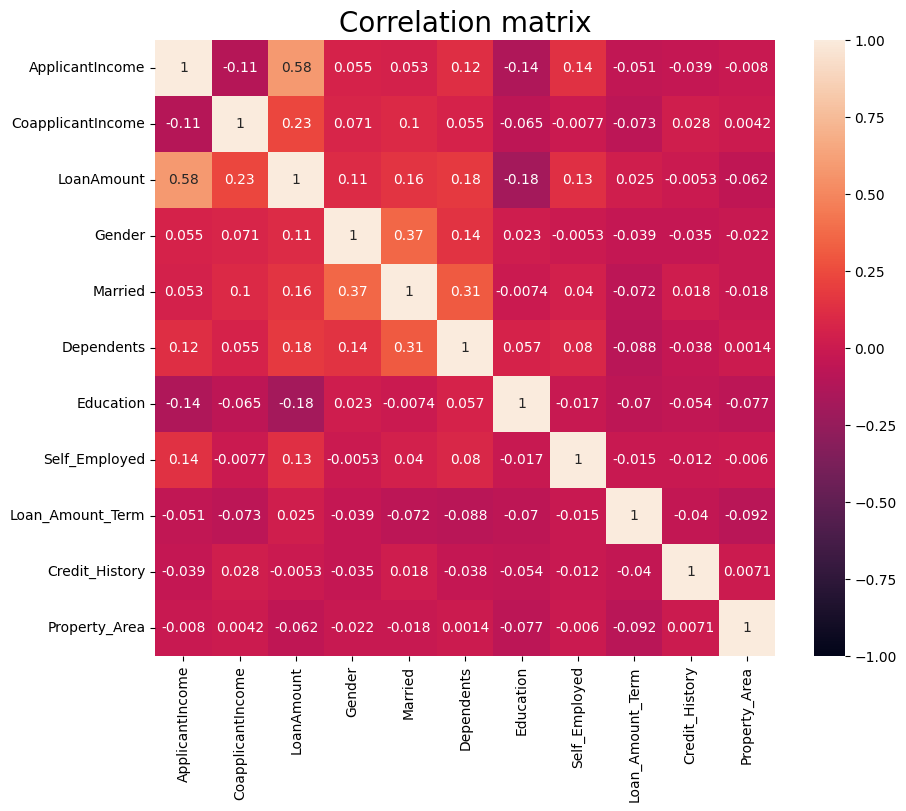

In [3]:
random_state = 0  # Graine pour la reproductibilité
df_credit = pd.read_csv("credit.csv").drop(columns=["Loan_ID"])  # Charge le CSV et enlève l'ID (inutile pour le modèle)

# Séparation des features (X) et de la cible (y) avec 80% train / 20% test
X_train_credit, X_test_credit, y_train_credit, y_test_credit = train_test_split(
    df_credit.iloc[:, :-1],  # Toutes les colonnes sauf la dernière = X
    df_credit.iloc[:, -1],   # Dernière colonne = y (la cible)
    test_size=0.2,
    random_state=random_state
)

# Création du pipeline de nettoyage pour Random Forest
pipeline_rf_full_washing = build_washing_pipeline(X_train_credit)  # Crée le pipeline à partir de X_train (ordinal par défaut)

# Transformation des données d’entraînement et de test avec le pipeline
X_train_credit_washed = pipeline_rf_full_washing.fit_transform(X_train_credit)  # Fit + transform sur le train
X_test_credit_washed = pipeline_rf_full_washing.transform(X_test_credit)  # Juste transform sur le test

# Encodage de la variable cible y (si elle est textuelle)
y_train_credit, y_test_credit = encode_y(y_train_credit, y_test_credit)

# Affiche la matrice de corrélation pour voir les relations entre variables
plot_correlation_matrix(X_train_credit_washed)


2/ A présent, utiliser Boruta avec un RandomForestClassifier pour sélectionner
automatiquement les features importantes. Combien et quelles sont les features
sélectionnées ?

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
!pip install boruta
from boruta import BorutaPy
import pprint


class BorutaFeatureSelector(BaseEstimator, TransformerMixin):  # Crée un sélecteur compatible scikit-learn
    def __init__(self, estimator):
        self.estimator = estimator  # Modèle à utiliser (ex : RandomForestClassifier)

    def fit(self, X, y):
        self.feature_names_ = X.columns.tolist()  # Sauvegarde les noms des colonnes
        self.selector = BorutaPy(  # Initialise Boruta
            estimator=self.estimator,
            n_estimators="auto",  # Laisse Boruta gérer le nombre d’arbres
            max_iter=10,  # Nombre d’itérations max
            random_state=random_state,
        )
        self.selector.fit(X.values, y)  # Entraîne Boruta sur les données
        self._sklearn_is_fitted = True  # Pour compatibilité avec scikit-learn
        self.show_ranking()  # Affiche les résultats
        return self  # Pour pouvoir enchaîner avec .transform()

    def transform(self, X):  # Sélectionne uniquement les colonnes retenues par Boruta
        check_is_fitted(self, attributes=["selector"])  # Vérifie que fit() a bien été appelé
        return X.iloc[:, self.selector.support_]  # Garde les colonnes sélectionnées (True dans le masque)

    def show_ranking(self):  # Affiche proprement le classement des features
        print("------Support and Ranking for each feature------")
        feature_info = [
            (self.selector.support_[i], self.selector.ranking_[i], feature)
            for i, feature in enumerate(self.feature_names_)
        ]
        feature_info.sort(key=lambda x: (x[1], x[2]))  # Tri par rang puis par nom
        digit = len(str(len(self.feature_names_)))  # Pour aligner l'affichage

        for support, ranking, feature in feature_info:
            status = "✅" if support else "❌"  # Emojis sympa pour visualiser les features gardées
            print(f"{status} Rank: {ranking:<{digit}} - {feature}")


def optimize_hyperparameters(X, y, estimator, param_distributions):
    randomized_search = RandomizedSearchCV(  # Optimisation aléatoire des hyperparamètres
        estimator=estimator,
        param_distributions=param_distributions,  # Dictionnaire des valeurs à tester
        scoring="accuracy",  # Critère utilisé pour scorer
        n_jobs=-1,  # Utilise tous les cœurs CPU dispo
        cv=5,  # Validation croisée à 5 plis
        return_train_score=True,  # Garde aussi le score sur l'entraînement
        random_state=random_state,
    )
    randomized_search.fit(X, y)  # Lance la recherche
    pprint.pp(randomized_search.best_params_)  # Affiche les meilleurs paramètres trouvés
    return randomized_search  # Retourne l’objet entraîné


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 2.1 MB/s eta 0:00:00


In [6]:
pipeline_select_feature = Pipeline(
    steps=[
        ("washing", build_washing_pipeline(X_train_credit)),
        (
            "feature_selection",
            BorutaFeatureSelector(
                estimator=RandomForestClassifier(class_weight="balanced")
            ),
        ),
    ]
)

pipeline_select_feature.fit(X_train_credit, y_train_credit)
X_train_credit_selected = pipeline_select_feature.transform(X_train_credit)
X_test_credit_selected = pipeline_select_feature.transform(X_test_credit)

------Support and Ranking for each feature------
✅ Rank: 1  - Credit_History
❌ Rank: 2  - LoanAmount
❌ Rank: 3  - ApplicantIncome
❌ Rank: 4  - CoapplicantIncome
❌ Rank: 5  - Property_Area
❌ Rank: 6  - Dependents
❌ Rank: 7  - Loan_Amount_Term
❌ Rank: 8  - Education
❌ Rank: 8  - Married
❌ Rank: 10 - Self_Employed
❌ Rank: 11 - Gender


3/ Créer un nouveau dataset ne contenant que les features sélectionnées par Boruta.
Réappliquez tout le pipeline de sélection de modèle sur ce nouveau dataset et comparez les
résultats obtenus sur le dataset complet. Qu’en pensez-vous ?

In [7]:
from sklearn.metrics import classification_report


def plot_confusion_matrix(estimator, X_train, y_train, X_test, y_test, title="Confusion Matrix"):
    # === Génère les rapports classification (train & test) sous forme de dictionnaire ===
    report_train = classification_report(y_train, estimator.predict(X_train), output_dict=True)
    report_test = classification_report(y_test, estimator.predict(X_test), output_dict=True)

    # Convertit les rapports en DataFrames
    df_train = pd.DataFrame(report_train).T
    df_test = pd.DataFrame(report_test).T

    # Combine les deux DataFrames côte à côte avec des noms d’onglets "Train" et "Test"
    df_combined = pd.concat([df_train, df_test], axis=1, keys=["Train", "Test"])

    # Repère la position de la ligne "accuracy"
    idx = df_combined.index.get_loc("accuracy")

    # Ajoute une ligne vide avant "accuracy" pour aérer le tableau
    df_combined = pd.concat([
        df_combined.iloc[:idx],
        pd.DataFrame(
            [[np.nan] * len(df_combined.columns)],
            columns=df_combined.columns,
            index=["\u200b"],  # Caractère invisible (non imprimable)
        ),
        df_combined.iloc[idx:],
    ])

    # Nettoie la ligne "accuracy" pour éviter la redondance (car seule "f1-score" est pertinente)
    for t1 in ["Train", "Test"]:
        for t2 in ["precision", "recall"]:
            df_combined.at["accuracy", (t1, t2)] = np.nan
        df_combined.at["accuracy", (t1, "support")] = df_combined.at["macro avg", (t1, "support")]

    # Affiche un tableau stylisé avec des couleurs, des formats arrondis, etc.
    display(
        df_combined.style.set_caption(f"Confusion Matrix of {title}")  # Titre du tableau
        .set_table_styles([
            {"selector": "caption", "props": [("caption-side", "bottom"), ("font-size", "1.25em")]},
            {"selector": "th", "props": [("text-align", "center")]},
            {"selector": "th.row_heading", "props": [("text-align", "right")]},
            {"selector": "td:hover", "props": [("background-color", "#ffff99"), ("color", "black")]},
        ], overwrite=False)
        .format({  # Format des valeurs numériques
            col: "{:.0f}" if col[1] == "support" else "{:.2f}"
            for col in df_combined.columns
        }, thousands=" ", na_rep="")  # Espace pour les milliers
        .set_sticky(axis=0)  # Fige les entêtes de ligne
        .set_sticky(axis=1)  # Fige les entêtes de colonnes
    )





    # === Affiche les matrices de confusion en 2 graphiques côte à côte ===
    fig, axs = plt.subplots(1, 2, figsize=(10, 10))  # 1 ligne, 2 colonnes
    axs = axs.flatten()

    # Matrice de confusion pour l'entraînement
    ConfusionMatrixDisplay.from_estimator(
        estimator, X_train, y_train, ax=axs[0], text_kw={"fontsize": 28}, colorbar=False
    )
    # Matrice de confusion pour le test
    ConfusionMatrixDisplay.from_estimator(
        estimator, X_test, y_test, ax=axs[1], text_kw={"fontsize": 28}, colorbar=False
    )

    axs[0].set_title("Train")
    axs[1].set_title("Test")
    plt.tight_layout()
    plt.suptitle(title, fontsize=24, y=0.78)  # Titre global de la figure
    plt.show()


{'model__n_estimators': 320,
 'model__min_samples_split': 43,
 'model__min_samples_leaf': 35,
 'model__max_features': None,
 'model__max_depth': 1,
 'model__criterion': 'gini',
 'model__bootstrap': False}


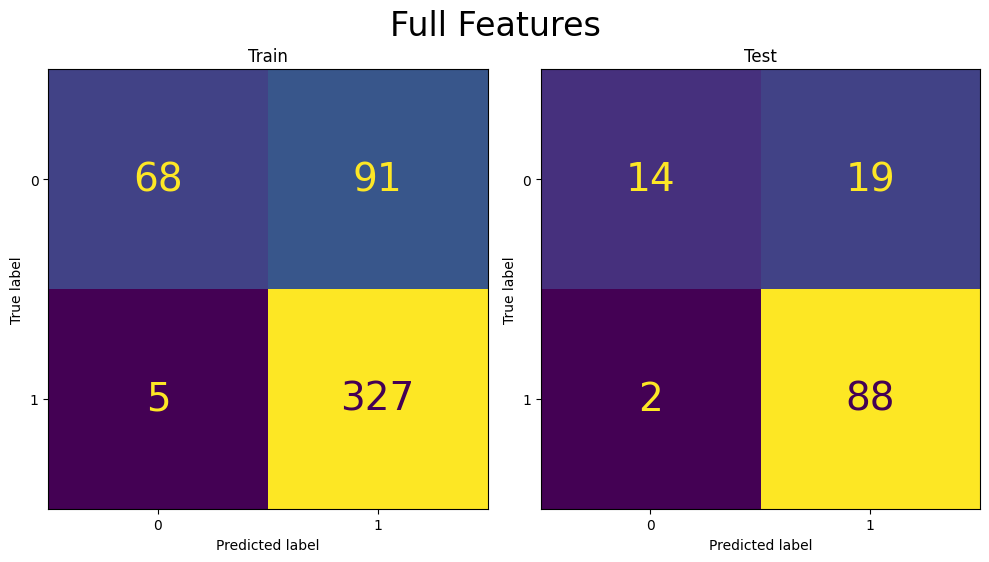

{'model__n_estimators': 190,
 'model__min_samples_split': 44,
 'model__min_samples_leaf': 24,
 'model__max_features': None,
 'model__max_depth': 95,
 'model__criterion': 'entropy',
 'model__bootstrap': False}


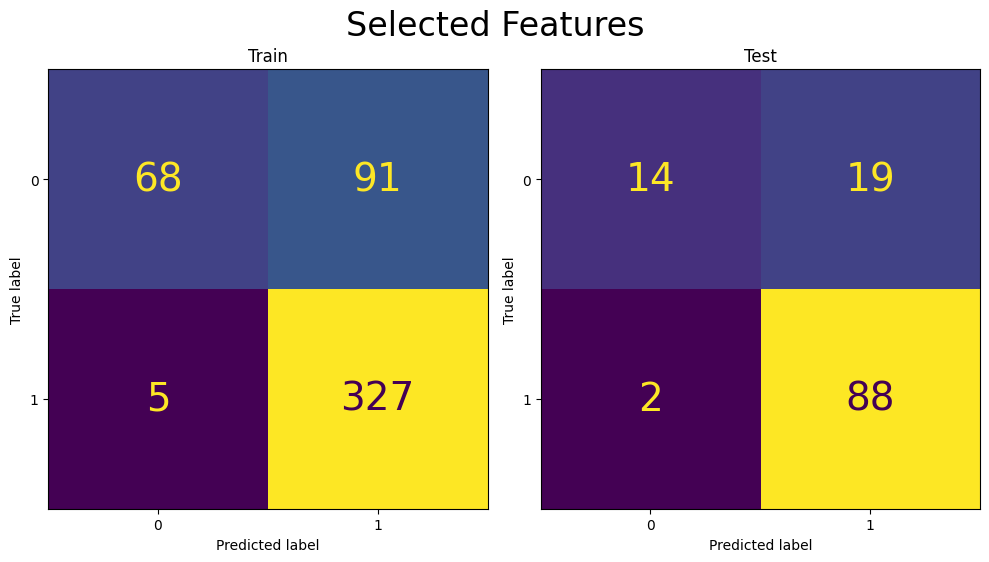

In [8]:
param_distributions = {  # Dictionnaire d’hyperparamètres pour RandomizedSearchCV
    "model__n_estimators": [int(x) for x in np.linspace(start=10, stop=500)],  # Nombre d’arbres
    "model__criterion": ["gini", "entropy"],  # Fonction d’impureté
    "model__max_depth": [None] + [int(x) for x in np.linspace(start=1, stop=100)],  # Profondeur max
    "model__min_samples_split": [int(x) for x in np.linspace(start=2, stop=50)],  # Min échantillons pour split
    "model__min_samples_leaf": [int(x) for x in np.linspace(start=1, stop=50)],  # Min échantillons dans une feuille
    "model__max_features": [None, "sqrt", "log2"],  # Nombre max de features par split
    "model__bootstrap": [True, False],  # Tirage avec ou sans remise
}







pipeline_rf_full = Pipeline(  # Pipeline complet : préprocessing + modèle
    steps=[
        ("washing", build_washing_pipeline(X_train_credit)),  # Nettoyage
        ("model", RandomForestClassifier(class_weight="balanced")),  # Modèle RF équilibré
    ]
)

# Optimisation des hyperparamètres sur toutes les features
rf_full = optimize_hyperparameters(
    X=X_train_credit_washed,
    y=y_train_credit,
    estimator=pipeline_rf_full,
    param_distributions=param_distributions,
).best_estimator_.named_steps["model"]  # Récupère uniquement le modèle final optimisé

# Affiche les matrices de confusion + classification report
plot_confusion_matrix(
    rf_full,
    X_train_credit_washed,
    y_train_credit,
    X_test_credit_washed,
    y_test_credit,
    title="Full Features"
)








# Random forest with selected dataset
pipeline_rf_simplified = Pipeline(
    steps=[
        ("washing", build_washing_pipeline(X_train_credit_selected)),  # Re-nettoie les features sélectionnées
        ("model", RandomForestClassifier(class_weight="balanced")),  # Même modèle
    ]
)

# On adapte X_test en gardant uniquement les colonnes sélectionnées (sinon erreur)
X_test_credit_selected = X_test_credit_washed[X_train_credit_selected.columns]

# Optimisation des hyperparamètres sur les données réduites
rf_simplified = optimize_hyperparameters(
    X=X_train_credit_selected,
    y=y_train_credit,
    estimator=pipeline_rf_simplified,
    param_distributions=param_distributions,
).best_estimator_.named_steps["model"]  # Même principe : on récupère juste le modèle

# Affichage des résultats pour ce modèle plus simple
plot_confusion_matrix(
    rf_simplified,
    X_train_credit_selected,
    y_train_credit,
    X_test_credit_selected,
    y_test_credit,
    title="Selected Features"
)


Exercice 2 : Explicabilité

1/  En  partant  du  meilleur  modèle  obtenu  sur  le  dataset  complet  (qui  sera  plus  intéressant
pour cet exercice sur l’explicabilité), afficher, analyser et expliquer un summary plot obtenu
en utilisant les SHap Values.

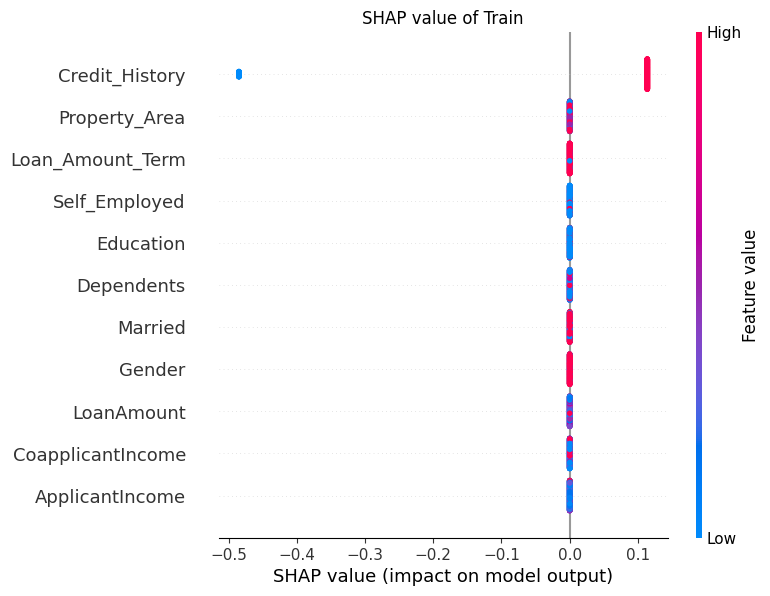

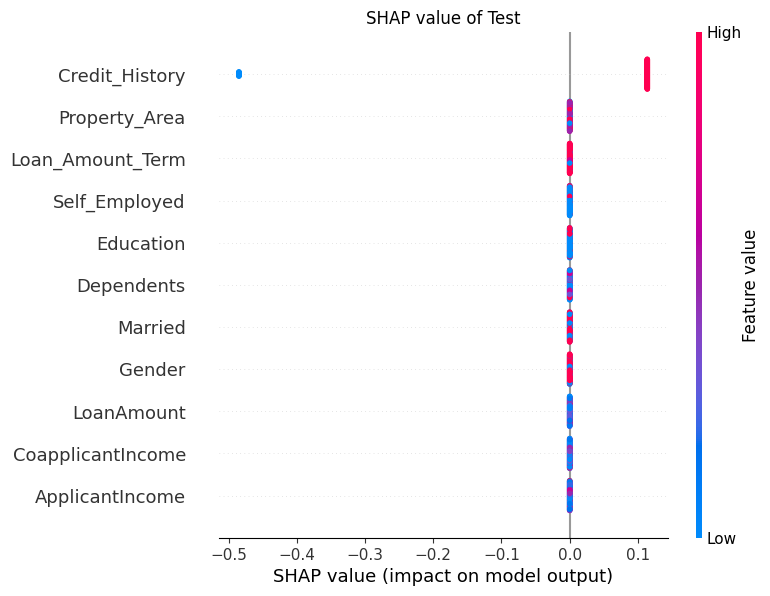

In [9]:
import shap


def explain(model, X_train, X_test):  # Fonction pour afficher les valeurs SHAP du modèle sur le train et le test
    explainer = shap.TreeExplainer(model, X_train)  # Crée un explainer adapté aux modèles basés sur des arbres
    shap_values_train = explainer(X_train, check_additivity=False)  # Calcule les valeurs SHAP sur les données d'entraînement
    shap_values_test = explainer(X_test, check_additivity=False)  # Calcule les valeurs SHAP sur les données de test

    # Résumé visuel des valeurs SHAP pour le training set
    shap.summary_plot(shap_values_train[:, :, 1], X_train, show=False)  # Affiche l'importance des variables pour la classe 1
    plt.title("SHAP value of Train")
    plt.show()

    # Résumé visuel des valeurs SHAP pour le test set
    shap.summary_plot(shap_values_test[:, :, 1], X_test, show=False)
    plt.title("SHAP value of Test")
    plt.show()


# Appel de la fonction pour expliquer le modèle RF sur les données complètes (full features)
explain(
    model=rf_full,
    X_train=X_train_credit_washed,
    X_test=X_test_credit_washed,
)


2/ Afficher et analyser les ICE plots de chacune des features du dataset.

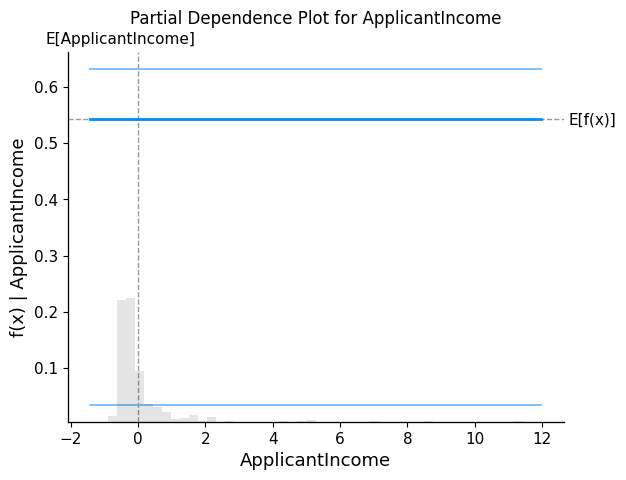

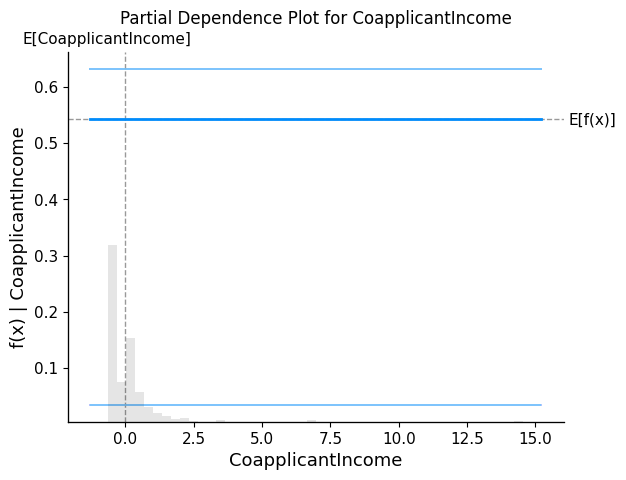

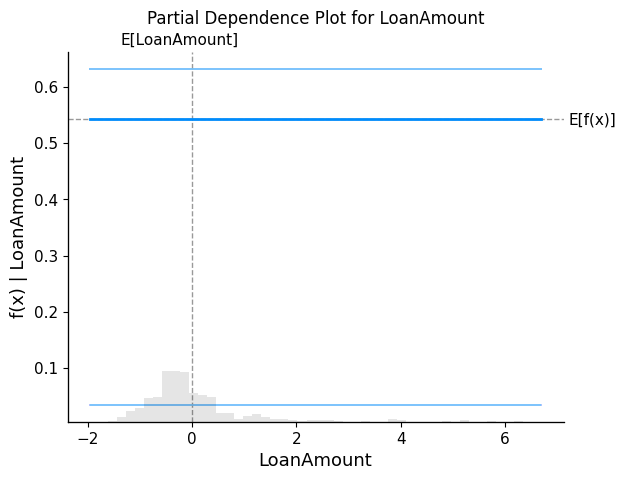

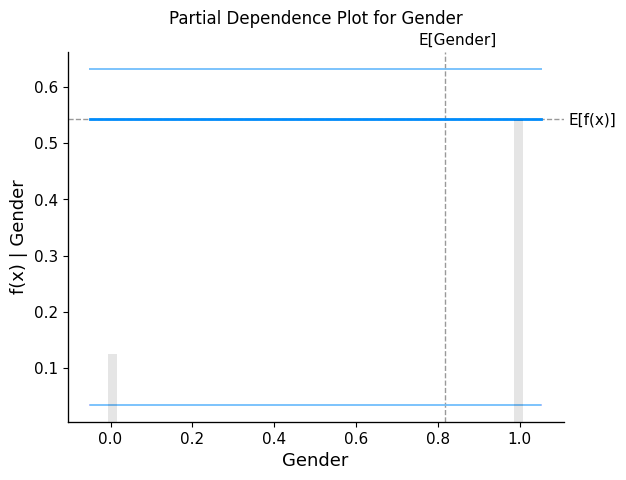

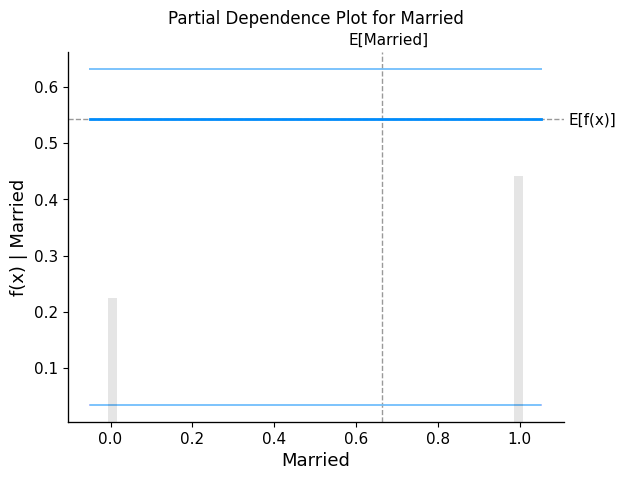

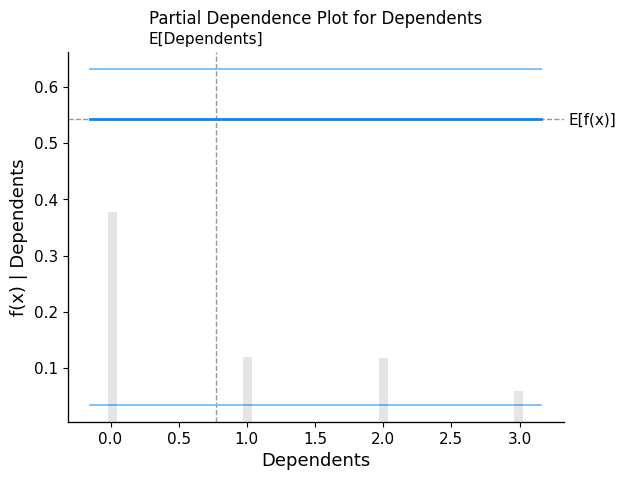

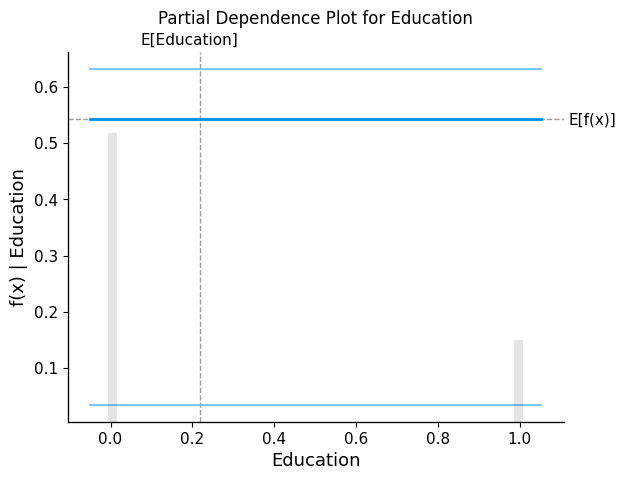

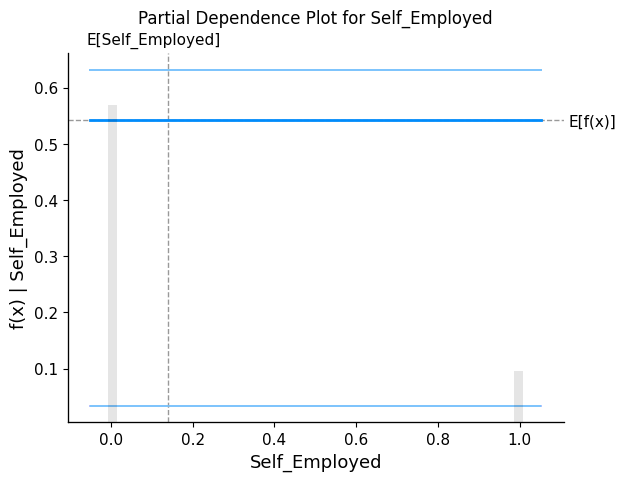

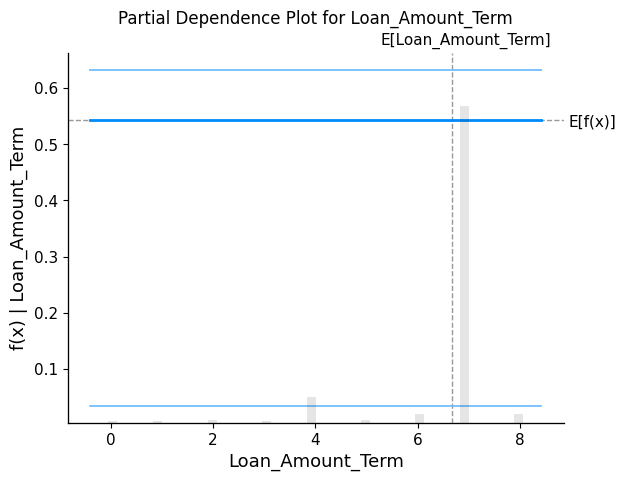

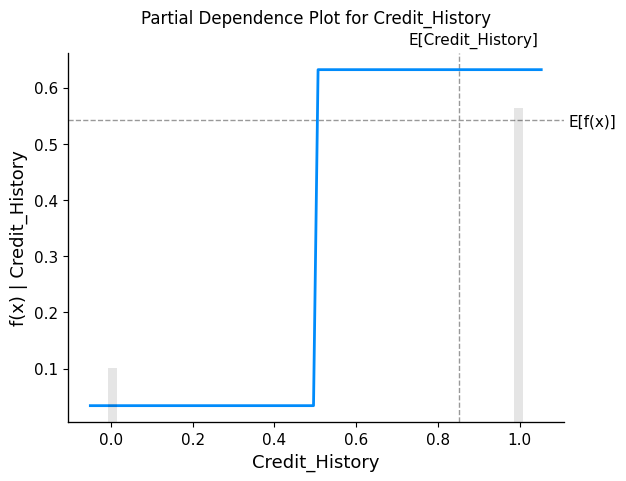

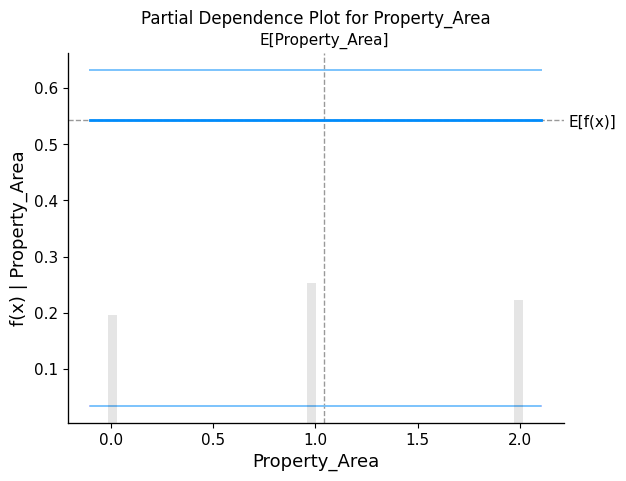

In [10]:
def plot_ICE(model, X):  # Fonction pour afficher les PDP/ICE pour chaque variable du modèle
    for feature in X.columns.tolist():  # Boucle sur chaque colonne du dataset
        shap.plots.partial_dependence(
            feature,  # Nom de la feature à afficher
            lambda x: model.predict_proba(x)[:, 1],  # Fonction de prédiction : proba de classe 1
            X,  # Données d'entrée
            model_expected_value=True,  # Affiche la moyenne globale du modèle
            feature_expected_value=True,  # Affiche la moyenne de la variable
            ice=True,  # Affiche aussi les Individual Conditional Expectations (lignes individuelles)
            show=False,  # Empêche SHAP de faire plt.show(), on le fait juste après
        )
        plt.title(f"Partial Dependence Plot for {feature}")  # Titre de la figure
        plt.show()  # Affiche le plot



# Exécution de la fonction pour expliquer le modèle Random Forest complet
plot_ICE(rf_full, X_train_credit_washed)


3/  Quelles  informations  sur  le  fonctionnement  du  modèle  tirez-vous  de  cette  analyse.
Attention, chaque modèle peut avoir un fonctionnement différent !

- Matrice de confusion:
Les matrices de confusion du modèle d'entraînement et du modèle de test sont identiques, donc l'algorithme Boruta a réussi à simplifier le modèle sans diminuer les performances de prédiction.
![image-3.png](attachment:image-3.png)
- summary_plot:
![image-4.png](attachment:image-4.png)
![image-5.png](attachment:image-5.png)
- Plot ICE
![image.png](attachment:image.png)
![image-2.png](attachment:image-2.png)

Exercice 3 : Ajout des derniers algorithmes de ML

1/ Ajouter et optimiser XGBoost à votre pipeline de sélection de modèles. En particulier,
vous devriez évaluer différentes profondeurs maximales d’arbres (entre 3 et 10), différents
nombres de pondérations par feuille (min_child_weight, entre 1 et 10), différentes valeurs
de gamma (entre 0 et 5), différents taux d’apprentissage (entre 0.01 et 0.3) et différents
nombres d’estimateurs (entre 25 et 200). Vous regarderez avant cela l’impact de ces
paramètres sur l’apprentissage.

In [12]:
def plot_parameter_impact(cv_results):  # Fonction pour visualiser l’effet de chaque hyperparamètre sur la précision
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))  # Crée une grille de 2 lignes × 3 colonnes
    axs = axs.flatten()  # Aplati la liste d’axes pour un accès plus facile

    for i, param in enumerate(param_distributions.keys()):  # Pour chaque hyperparamètre testé
        sns.scatterplot(
            data=cv_results,  # Les résultats du RandomizedSearchCV (cv_results_)
            x=f"param_{param}",  # L’hyperparamètre actuel sur l’axe des x
            y="mean_test_score",  # La précision moyenne en validation croisée sur l’axe des y
            ax=axs[i]  # Axe courant
        )
        axs[i].set_title(f"Impact of {param} on Accuracy")  # Titre du graphe
        axs[i].set_xlabel(param)
        axs[i].set_ylabel("Mean Accuracy")
        axs[i].grid(True)

    fig.delaxes(axs[-1])  # Supprime la dernière case vide (6e plot) si trop de graphes
    plt.suptitle("Impact des hyperparamètres sur la précision (accuracy)", fontsize=24)
    plt.tight_layout()
    plt.show()


{'model__n_estimators': 132,
 'model__min_child_weight': 6,
 'model__max_depth': 5,
 'model__learning_rate': np.float64(0.14020408163265308),
 'model__gamma': np.float64(0.6122448979591837)}


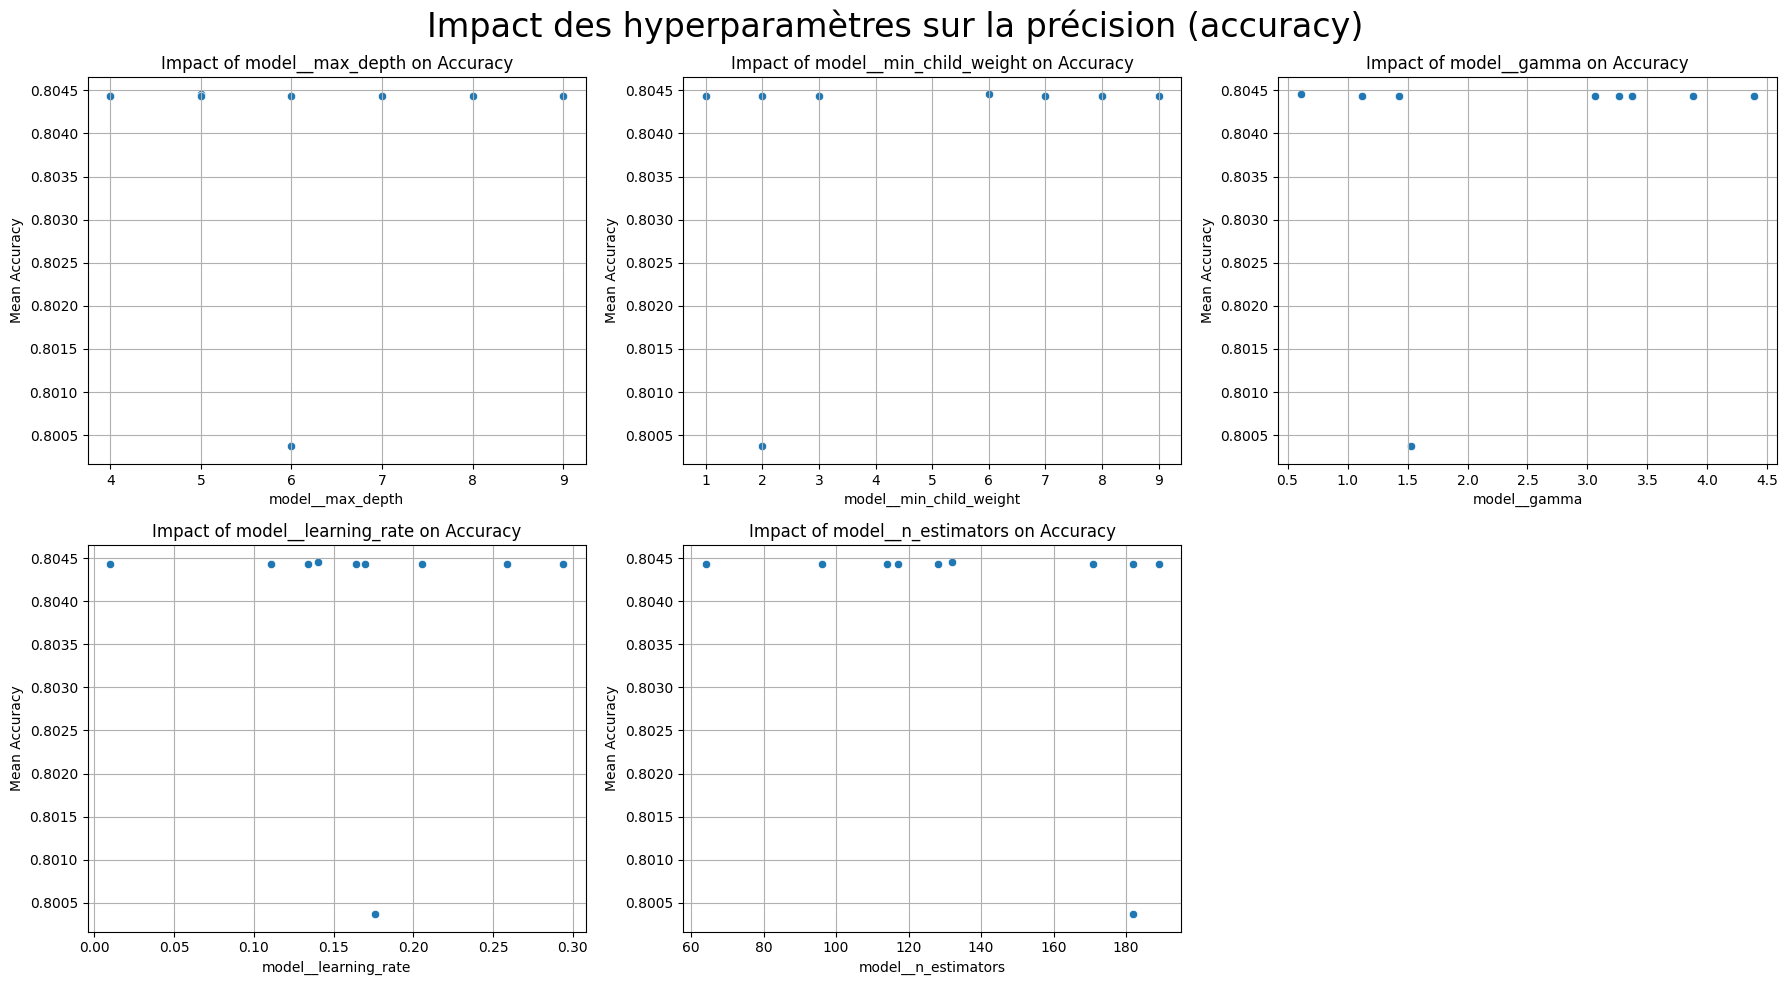

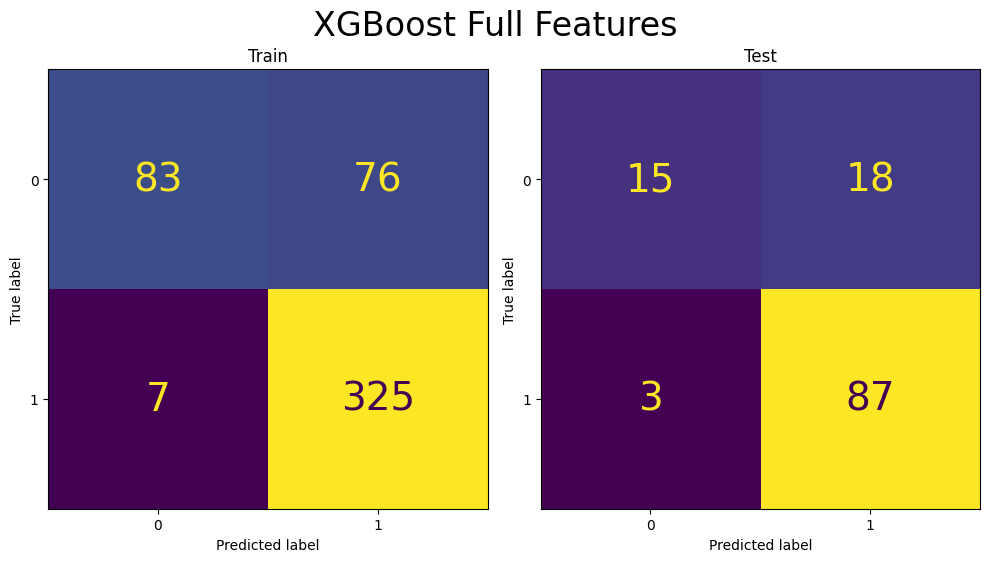

In [13]:
from xgboost import XGBClassifier

param_distributions = {
    "model__max_depth": [int(x) for x in np.linspace(start=3, stop=10)],  # Profondeur max des arbres
    "model__min_child_weight": [int(x) for x in np.linspace(start=1, stop=10)],  # Min d’exemples dans une feuille
    "model__gamma": [x for x in np.linspace(start=0, stop=5)],  # Gain minimum pour faire un split
    "model__learning_rate": [x for x in np.linspace(start=0.01, stop=0.3)],  # Taux d’apprentissage
    "model__n_estimators": [int(x) for x in np.linspace(start=25, stop=200)],  # Nombre d’arbres
}

pipeline_xgb = Pipeline(
    steps=[
        ("washing", build_washing_pipeline(X_train_credit)),  # Pipeline de nettoyage
        (
            "model",
            XGBClassifier(
                objective="binary:logistic",  # Pour un problème binaire
                eval_metric="logloss",  # Métrique de perte
                random_state=random_state,
            ),
        ),
    ]
)


search_result = optimize_hyperparameters(
    X=X_train_credit_washed,  # Données déjà "washed"
    y=y_train_credit,
    estimator=pipeline_xgb,
    param_distributions=param_distributions,
)

plot_parameter_impact(pd.DataFrame(search_result.cv_results_))  # Affiche les scatterplots


plot_confusion_matrix(
    search_result.best_estimator_,  # Pipeline complet avec le meilleur modèle
    X_train_credit_washed,
    y_train_credit,
    X_test_credit_washed,
    y_test_credit,
    title="XGBoost Full Features"
)


2/ Ajouter et tester différentes architectures de perceptron multicouche. Voici deux exemples à tester :
- 2 couches cachées avec une fonction d’activation ReLU : 1ère de 64 neurones et 2nde de 32 neurones
- 3 couches cachées avec une fonction d’activation ReLU : 1ère de 128 neurones, 2nde de 64 neurones et une 3ème de 32 neurones
Vous pourrez tester toute autre architecture de votre choix.

In [14]:
from sklearn.neural_network import MLPClassifier

params_mlp_classifier = {
    "activation": "relu",  # Fonction d'activation (ReLU = rapide + efficace)
    "solver": "adam",  # Optimiseur efficace pour MLP
    "max_iter": 1000,  # Nombre d'itérations max (epochs)
    "random_state": random_state,  # Graine pour reproductibilité
}

models = {
    "MLP Classifier [64, 32]": MLPClassifier(  # Deux couches cachées : 64 → 32 neurones
        hidden_layer_sizes=(64, 32),
        **params_mlp_classifier,  # Injecte les params communs
    ),
    "MLP Classifier [128, 64, 32]": MLPClassifier(  # Trois couches : 128 → 64 → 32
        hidden_layer_sizes=(128, 64, 32),
        **params_mlp_classifier,
    ),
}

3/ Relancer votre pipeline sur le dataset et évaluer l’intérêt de ces nouveaux algorithmes
pour ce dataset.

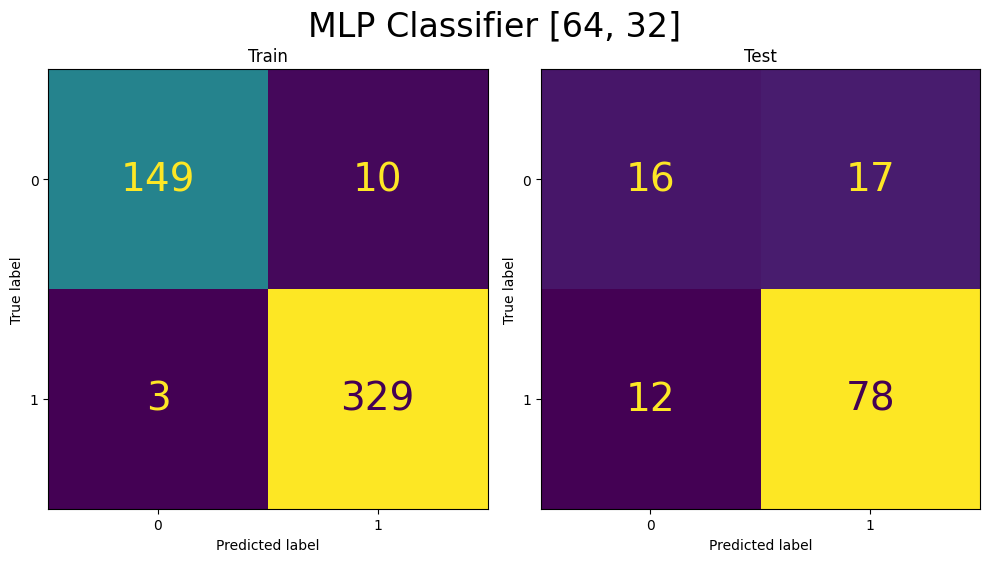

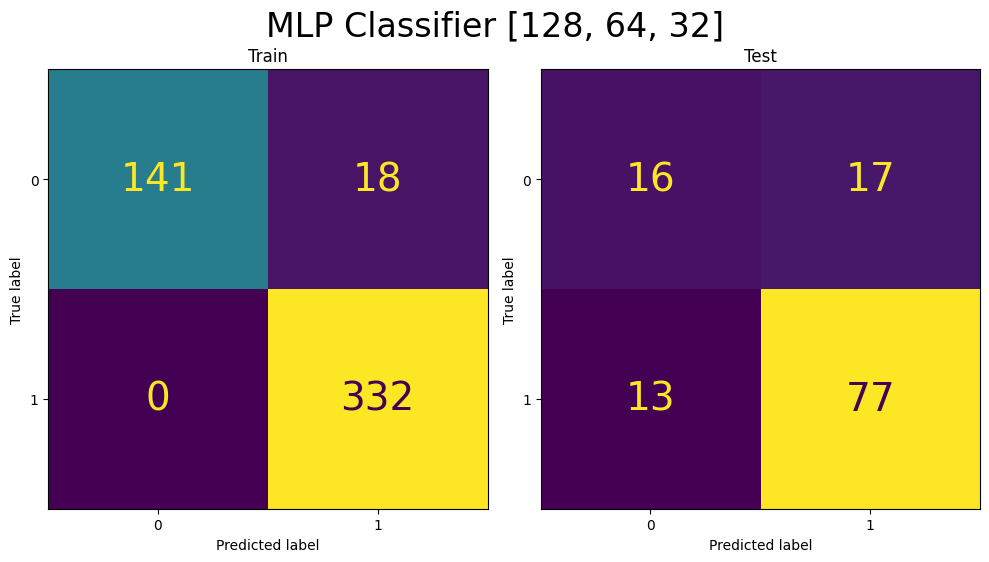

In [15]:
for name, model in models.items():  # Boucle sur chaque modèle MLP et son nom
    pipeline_mlp_classifier = Pipeline(  # Pipeline : nettoyage + modèle MLP
        steps=[
            ("washing", build_washing_pipeline(X_train_credit, encoder="onehot")),  # Encodage OneHot pour les MLP (important)
            ("model", model),  # Modèle MLP actuel
        ]
    )

    pipeline_mlp_classifier.fit(X_train_credit, y_train_credit)  # Entraîne le pipeline complet (preprocessing + MLP)

    plot_confusion_matrix(  # Affiche performances sur train et test avec matrice + classification report
        pipeline_mlp_classifier,
        X_train_credit,
        y_train_credit,
        X_test_credit,
        y_test_credit,
        title=name  # Titre correspondant à l’architecture MLP
    )


Exercice 4 : Construire un pipeline pour la régression (à faire à la
maison)

Reprendre ce même travail pour un dataset de régression proposé en tronc commun
(insurance).

In [20]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tabulate import tabulate


def regression_report(pipelines, X_train, X_test, y_train, y_test, printer="styler"):
    metrics = ["MSE", "RMSE", "MAE", "R2"]  # Liste des métriques à afficher
    reports = []  # Liste pour stocker les résultats

    for name, model in pipelines.items():  # Boucle sur tous les modèles du dictionnaire
        y_train_pred = model.predict(X_train)  # Prédictions sur le train
        y_test_pred = model.predict(X_test)  # Prédictions sur le test

        train_results = [
            mean_squared_error(y_train, y_train_pred),
            np.sqrt(mean_squared_error(y_train, y_train_pred)),  # RMSE
            mean_absolute_error(y_train, y_train_pred),
            r2_score(y_train, y_train_pred),
        ]

        test_results = [
            mean_squared_error(y_test, y_test_pred),
            np.sqrt(mean_squared_error(y_test, y_test_pred)),  # RMSE
            mean_absolute_error(y_test, y_test_pred),
            r2_score(y_test, y_test_pred),
        ]

        reports.append(
            pd.DataFrame(  # Crée un DataFrame avec les scores train/test pour ce modèle
                {(name, "Train"): train_results, (name, "Test"): test_results},
                index=metrics,
            )
        )

    if printer == "styler":
        display(
            pd.concat(reports, axis=1)  # Concatène tous les DataFrames
            .style.set_caption(
                f"=== Regression Report: {model.named_steps['model'].__class__.__name__} ==="
            )
            .set_table_styles(
                [
                    {"selector": "th", "props": [("text-align", "center")]},
                    {"selector": "th.row_heading", "props": [("text-align", "left")]},
                ],
                overwrite=False,
            )
            .format(precision=2, thousands=" ")  # Formate joliment les chiffres
            .set_sticky(axis=0)
            .set_sticky(axis=1)
        )



    elif printer == "tabulate":
        # Version texte (console) — ne gère pas les colonnes multiples
        print(
            f"=== Regression Report: {model.__class__.__name__} ===\n",
            tabulate(
                pd.concat(reports, axis=1),
                headers="keys",
                tablefmt="fancy_grid",
                stralign="center",
                floatfmt=".2f",
            ),
            sep="",
        )

    else:
        raise ValueError("Printer must be 'df' or 'tabulate'")  # Erreur si mauvais type de sortie demandé


In [22]:
df_insurance = pd.read_csv("insurance.csv")

X_train_insurance, X_test_insurance, y_train_insurance, y_test_insurance = (
    train_test_split(
        df_insurance.iloc[:, :-1], # Toutes les colonnes sauf la dernière → features
        df_insurance.iloc[:, -1],  # Dernière colonne → cible (ex: charges)
        test_size=0.2, # 80% train, 20% test
        random_state=random_state,# Reproductibilité

    )
)

params_mlp_regressor = {
    "activation": "relu",
    "solver": "adam",
    "max_iter": 10000, # Beaucoup d'itérations car MLP a besoin de temps pour converger
    "random_state": random_state,
}

models = {
    "MLP Regressor [64, 32]": MLPRegressor(
        hidden_layer_sizes=(64, 32), # Deux couches cachées
        **params_mlp_regressor,
    ),
    "MLP Regressor [128, 64, 32]": MLPRegressor(
        hidden_layer_sizes=(128, 64, 32), # Trois couches cachées
        **params_mlp_regressor,
    ),
}

pipelines_mlp_regressor = {}  # Dictionnaire pour stocker les pipelines entraînés

for name, model in models.items():
    pipeline_mlp_regressor = Pipeline(
        steps=[
            ("washing", build_washing_pipeline(X_train_insurance, encoder="onehot")),  # Nettoyage + OneHot
            ("model", model),  # MLP actuel
        ]
    )
    pipeline_mlp_regressor.fit(X_train_insurance, y_train_insurance)  # Entraîne le pipeline
    pipelines_mlp_regressor[name] = pipeline_mlp_regressor  # Stocke le pipeline dans le dict


In [ ]:
regression_report(
    pipelines_mlp_regressor,
    X_train_insurance,
    X_test_insurance,
    y_train_insurance,
    y_test_insurance,
)